##Corpora

In [205]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
newsgroups_train = fetch_20newsgroups(subset='train')

In [206]:
from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [207]:
print(newsgroups_train.filenames.shape);
print(newsgroups_train.target.shape);
print(newsgroups_train.target[:10]);

(11314,)
(11314,)
[ 7  4  4  1 14 16 13  3  2  4]


In [267]:
cats = ['sci.crypt','sci.electronics','sci.med','sci.space',]
#cats = ['sci.med','sci.space']

newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, random_state=0)
newsgroups_test = fetch_20newsgroups(subset='test',categories=cats, shuffle=True, random_state=0)


list(newsgroups_train.target_names)

['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']

In [209]:
print(newsgroups_train.filenames.shape);
print(newsgroups_train.target.shape);
print(newsgroups_train.target[:10]);

(2373,)
(2373,)
[2 3 0 0 0 1 3 2 2 3]


In [268]:
print(newsgroups_test.filenames.shape);
print(newsgroups_test.target.shape);
print(newsgroups_test.target[:10]);

(1579,)
(1579,)
[3 0 2 1 2 1 3 3 2 0]


## Vetorização

In [270]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

(2373, 38683)

In [211]:
vectors.nnz / float(vectors.shape[0])

164.43826380109567

##Tokenização

In [212]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
newsgroups_train_counts = count_vect.fit_transform(newsgroups_train.data)

In [213]:
newsgroups_train_counts.shape

(2373, 38683)

In [214]:
count_vect.vocabulary_.get(u'country')


11807

##Frequência

In [215]:
from sklearn.feature_extraction.text import TfidfTransformer
#tf_transformer = TfidfTransformer(use_idf=False).fit(newsgroups_train_counts)
#newsgroups_train_tf = tf_transformer.transform(newsgroups_train_counts)
#newsgroups_train_tf.shape

In [216]:
tfidf_transformer = TfidfTransformer()
newsgroups_train_tfidf = tfidf_transformer.fit_transform(newsgroups_train_counts)
newsgroups_train_tfidf.shape

(2373, 38683)

##Classificador 

In [217]:
from sklearn.naive_bayes import MultinomialNB
classification_nb = MultinomialNB()
classification = classification_nb.fit(newsgroups_train_tfidf, newsgroups_train.target)

In [218]:
newsgroups_train.target_names

['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']

In [219]:
docs_new = ['The doctor is good', 'The biggest planet']
newsgroups_new_counts = count_vect.transform(docs_new)
newsgroups_new_tfidf = tfidf_transformer.transform(newsgroups_new_counts)

predicted = classification.predict(newsgroups_new_tfidf)

for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, newsgroups_train.target_names[category]))

'The doctor is good' => sci.med
'The biggest planet' => sci.space


##Condutor

In [220]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB()),])

In [221]:
text_clf.fit(newsgroups_train.data, newsgroups_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

##Desempenho do classificador 

In [264]:
import numpy as np
docs_test = newsgroups_test.data
predicted = text_clf.predict(docs_test)
np.mean(predicted == newsgroups_test.target)

0.9373020899303357

In [265]:
print(len(newsgroups_test.target))
print(len(newsgroups_train.target))


1579
2373


In [224]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None)),])

In [225]:
text_clf.fit(newsgroups_train.data, newsgroups_train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [226]:
predicted = text_clf.predict(docs_test)

In [227]:
np.mean(predicted == newsgroups_test.target)


0.9373020899303357

#Avaliação do Classificador 

In [228]:
from sklearn import metrics 

##Classification report

In [229]:
print(metrics.classification_report(newsgroups_test.target, predicted,target_names=newsgroups_test.target_names))

                 precision    recall  f1-score   support

      sci.crypt       0.98      0.94      0.96       396
sci.electronics       0.85      0.95      0.90       393
        sci.med       0.96      0.90      0.93       396
      sci.space       0.97      0.96      0.96       394

       accuracy                           0.94      1579
      macro avg       0.94      0.94      0.94      1579
   weighted avg       0.94      0.94      0.94      1579



##Roc curve

In [230]:
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [231]:
clf_svc =  LinearSVC(C=1, tol=0.01)


In [232]:
clf_kn =  KNeighborsClassifier()

In [271]:
vectors_test = vectorizer.transform(newsgroups_test.data)

In [272]:
vectors_test.shape

(1579, 38683)

In [235]:
vectors.shape

(2373, 38683)

In [236]:
len(newsgroups_train.target)

2373

In [237]:
len(newsgroups_test.target)

1579

In [238]:
predicted.shape

(1579,)

In [239]:
def ROC_multi_class(Xtr, ytr, Xtt, ytt, clf):
    
    classes = [0,1, 2, 3]
    ytr = label_binarize(ytr, classes=classes)
    n_classes = ytr.shape[1]
    
    classifier = OneVsRestClassifier(clf)
    classifier.fit(Xtr, ytr)
    if (clf == clf_svc):
        y_pred_score = classifier.decision_function(Xtt)
    else:
        y_pred_score = classifier.predict_proba(Xtt)
    
    ytt = label_binarize(ytt, classes=classes)
    
 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytt[:, i], y_pred_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

  
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i+1, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of multi-class')
    plt.legend(loc="lower right")
    plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


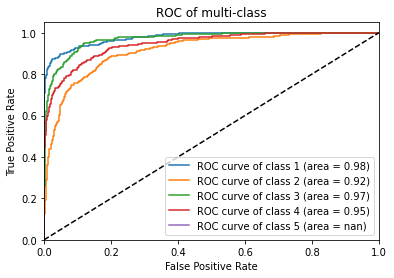

In [273]:
ROC_multi_class(vectors, newsgroups_train.target, vectors_test, newsgroups_test.target, classification_nb)

/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


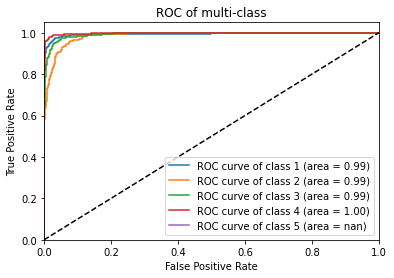

In [274]:
ROC_multi_class(vectors, newsgroups_train.target, vectors_test, newsgroups_test.target, clf_svc)

/usr/local/lib/python3.8/dist-packages/sklearn/multiclass.py:79: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


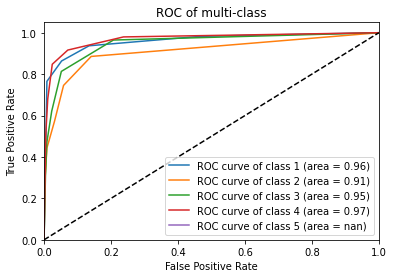

In [275]:
ROC_multi_class(vectors, newsgroups_train.target, vectors_test, newsgroups_test.target,clf_kn)